# Pipeline processing

This notebook demonstrates the continuum imaging and ICAL pipelines.

In [1]:
% matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from data_models.polarisation import PolarisationFrame
from data_models.parameters import get_parameter

from processing_components.calibration.calibration import solve_gaintable
from processing_components.calibration.operations import apply_gaintable, create_gaintable_from_blockvisibility
from processing_components.visibility.base import create_blockvisibility
from processing_components.skycomponent.operations import create_skycomponent
from processing_components.image.operations import show_image, export_image_to_fits, qa_image
from processing_components.visibility.iterators import vis_timeslice_iter
from processing_components.visibility.coalesce import convert_visibility_to_blockvisibility
from processing_components.util.testing_support import create_named_configuration, create_low_test_image_from_gleam, \
    simulate_gaintable
from processing_components.imaging.base import create_image_from_visibility, advise_wide_field
from processing_components.imaging.imaging_functions import invert_function, predict_function
from processing_components.functions.pipeline_functions import ical

import logging

log = logging.getLogger()
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler(sys.stdout))


We create a graph to make the visibility. The parameter rmax determines the distance of the furthest antenna/stations used. All over parameters are determined from this number.

In [2]:
nfreqwin=5
ntimes=11
rmax=300.0
frequency=numpy.linspace(0.8e8,1.2e8,nfreqwin)
channel_bandwidth=numpy.array(nfreqwin*[frequency[1]-frequency[0]])
times = numpy.linspace(-numpy.pi/3.0, numpy.pi/3.0, ntimes)
phasecentre=SkyCoord(ra=+30.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox='J2000')

lowcore = create_named_configuration('LOWBD2-CORE', rmax=rmax)

block_vis = create_blockvisibility(lowcore, times, frequency=frequency, channel_bandwidth=channel_bandwidth,
                     weight=1.0, phasecentre=phasecentre,
                     polarisation_frame=PolarisationFrame("stokesI"))

create_blockvisibility: 11 rows, 0.015 GB


In [3]:
wprojection_planes=1
advice=advise_wide_field(block_vis, guard_band_image=4.0, delA=0.02,
                             wprojection_planes=wprojection_planes)

vis_slices = advice['vis_slices']
npixel=advice['npixels2']
cellsize=advice['cellsize']

advise_wide_field: Maximum wavelength 3.747 (meters)
advise_wide_field: Minimum wavelength 2.498 (meters)
advise_wide_field: Maximum baseline 229.0 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.107069 (rad) 6.135 (deg)
advise_wide_field: Image field of view 0.428275 (rad) 24.538 (deg)
advise_wide_field: Synthesized beam 0.004366 (rad) 0.250 (deg)
advise_wide_field: Cellsize 0.001455 (rad) 0.083 (deg)
advice_wide_field: Npixels per side = 294
advice_wide_field: Npixels (power of 2, 3) per side = 384
advice_wide_field: W sampling for full image = 0.3 (wavelengths)
advice_wide_field: W sampling for primary beam = 5.6 (wavelengths)
advice_wide_field: Time sampling for full image = 41.7 (s)
advice_wide_field: Time sampling for primary beam = 666.8 (s)
advice_wide_field: Frequency sampling for full image = 57881.5 (Hz)
advice_wide_field: Frequency sampling for primary beam = 926104.3 (Hz)
advice_wide_field: Number of planes in w sta

In [4]:
gleam_model = create_low_test_image_from_gleam(npixel=npixel, frequency=frequency,
    channel_bandwidth=channel_bandwidth, cellsize=cellsize, phasecentre=phasecentre, applybeam=True, flux_limit=1.0)

create_low_test_skycomponents_from_gleam: 514 sources above flux limit 1.000
create_low_test_beam: primary beam is defined at 100.000 MHz
Quality assessment:
	Origin: qa_image
	Context: create_low_test_image_from_gleam
	Data:
		shape: '(5, 1, 384, 384)'
		max: '8.11812218679743'
		min: '0.0'
		rms: '0.02872062898847819'
		sum: '278.25643510925596'
		medianabs: '0.0'
		median: '0.0'



In [5]:
export_image_to_fits(gleam_model, '%s/gleam_model.fits'
                     % (results_dir))

In [6]:
predicted_vis = predict_function(block_vis, gleam_model, vis_slices=51, context='wstack')

In [8]:
predicted_vis = predict_function(block_vis, gleam_model, vis_slices=51, context='wstack')
block_vis=convert_visibility_to_blockvisibility(predicted_vis)
gt = create_gaintable_from_blockvisibility(block_vis)
gt = simulate_gaintable(gt, phase_error=1.0)
blockvis = apply_gaintable(block_vis, gt)

In [9]:
model = create_image_from_visibility(block_vis, npixel=npixel, frequency=[numpy.average(frequency)], nchan=1,
    channel_bandwidth=[numpy.sum(channel_bandwidth)], cellsize=cellsize, phasecentre=phasecentre)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel MFS Image at <SkyCoord (ICRS): (ra, dec) in deg
    (30., -60.)>, starting frequency 100000000.0 Hz, and bandwidth [50000000.] Hz
create_image_from_visibility: uvmax = 101.803178 wavelengths
create_image_from_visibility: Critical cellsize = 0.004911 radians, 0.281405 degrees
create_image_from_visibility: Cellsize          = 0.001455 radians, 0.083383 degrees


In [10]:
dirty, sumwt = invert_function(predicted_vis, model, vis_slices=vis_slices, dopsf=False, context='wstack')

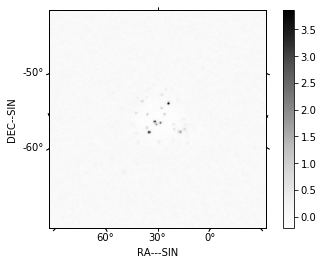

In [11]:
show_image(dirty)
plt.show()

In [12]:
deconvolved, residual, restored = ical(block_vis=blockvis, model=model, vis_slices=vis_slices, timeslice='auto',
                                       algorithm='hogbom', niter=1000, fractional_threshold=0.1, threshold=0.1,
                                       context='wstack', nmajor=5, gain=0.1, 
                                       T_first_selfcal=2,
                                       G_first_selfcal=3,
                                       B_first_selfcal=4,
                                       global_solution=False)

ical: Performing 5 major cycles
Maximum in residual image is 3.856761
ical: Start of major cycle 0 of 5
deconvolve_cube : PSF support = +/- 192 pixels
deconvolve_cube : PSF shape (1, 1, 384, 384)
deconvolve_cube : Hogbom clean of each polarisation and channel separately
deconvolve_cube : Processing pol 0, channel 0
hogbom  Max abs in dirty image = 3.856761 Jy/beam
hogbom  Start of minor cycle
hogbom  This minor cycle will stop at 1000 iterations or peak < 0.385676 (Jy/beam)
hogbom : Timing for setup: 0.003 (s) for dirty shape (384, 384), PSF shape (384, 384)
hogbom  Minor cycle 0, peak 3.856761359311541 at [219, 210]
hogbom  Minor cycle 100, peak 0.7132244395783337 at [176, 172]
hogbom  Stopped at iteration 185, peak 0.381848697688034 at [234, 198]
hogbom  End of minor cycle
 Timing for clean: 0.159 (s) for dirty (384, 384), PSF (384, 384) , 186 iterations, time per clean 0.857 (ms)
Maximum in residual image is 0.43296039440395656
ical: End of major cycle
ical: Start of major cycle 1 o

Quality assessment:
	Origin: qa_image
	Context: Clean image
	Data:
		shape: '(1, 1, 384, 384)'
		max: '3.252630376848953'
		min: '-0.012032652062622783'
		rms: '0.01695829658304171'
		sum: '30.043031858266115'
		medianabs: '0.0'
		median: '0.0'



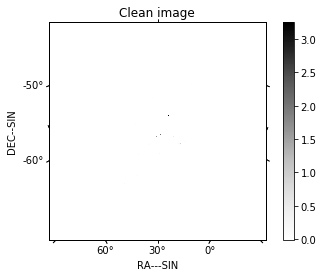

Quality assessment:
	Origin: qa_image
	Context: Residual clean image
	Data:
		shape: '(1, 1, 384, 384)'
		max: '0.11019065471877194'
		min: '-0.10804436201377553'
		rms: '0.029189964092890344'
		sum: '2.200637044421221'
		medianabs: '0.01914808819333575'
		median: '-0.0006871489772548988'



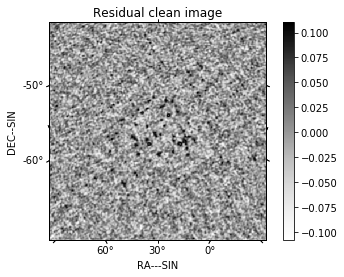

Quality assessment:
	Origin: qa_image
	Context: Restored clean image
	Data:
		shape: '(1, 1, 384, 384)'
		max: '3.8961265456523773'
		min: '-0.11609911000540696'
		rms: '0.07378451244832718'
		sum: '616.4199201342632'
		medianabs: '0.01929527331192374'
		median: '-0.00042713652735149597'



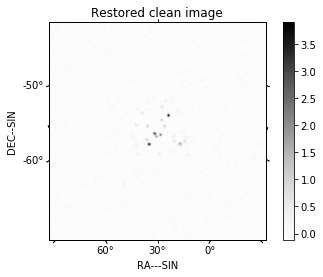

In [13]:
f = show_image(deconvolved, title='Clean image')
print(qa_image(deconvolved, context='Clean image'))
plt.show()

f = show_image(residual, title='Residual clean image')
print(qa_image(residual, context='Residual clean image'))
plt.show()
export_image_to_fits(residual, '%s/imaging-ical_residual.fits'
                     % (results_dir))

f = show_image(restored, title='Restored clean image')
print(qa_image(restored, context='Restored clean image'))
plt.show()
export_image_to_fits(restored, '%s/imaging-ical_restored.fits'
                     % (results_dir))